In [164]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

from tabulate import tabulate

os.environ['CUDA_VISIBLE_DEVICES']= '6'
pd.set_option('display.max_colwidth', None)
sys.path.append('/workspace/computationally-undermining-arguments/scripts/')
sys.path.append('/workspace/computationally-undermining-arguments/src-py')

In [166]:
%autoreload

import torch
import nltk
import numpy as np
import pandas as pd
import json
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from vul_classification import *

In [253]:
import evaluation

In [167]:
import tensorflow as tf
from sklearn.metrics import ndcg_score

In [168]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data Preparation:

In [6]:
training_df = pd.read_json('/workspace/ceph_data/argument-undermining/data/gen_training.json')
testing_df = pd.read_json('/workspace/ceph_data/argument-undermining/data/gen_testing.json')
validation_df = pd.read_json('/workspace/ceph_data/argument-undermining/data/gen_validation.json')

In [7]:
def group_df(df):
    df = df.groupby('title').agg({
        'title' : lambda x: list(x)[0],
        'full_post': lambda x: list(x)[0],
        'premise_counter_premise_pair': lambda x : [attack for comment in list(x) for attack in comment],
    }).reset_index(drop=True)
    
    return df

In [8]:
training_df = group_df(training_df)
testing_df  = group_df(testing_df)
valid_df    = group_df(validation_df)

In [9]:
print(len(training_df))
print(len(testing_df))
print(len(validation_df))

11381
1441
3149


In [29]:
def convert_to_json(df):
    ranking_problems = []
    for idx, row in df.iterrows():
            documents = []
            attacked_sents = [x[0].lower() for x in row['premise_counter_premise_pair']]
            for sent_idx, sent in enumerate(row['full_post']):
                documents.append({"relevance": 1 if sent.lower() in attacked_sents else 0, 
                 "docText": sent})
            
            ranking_problems.append({
                "queryText": row['title'],
                "documents": documents
            })
    
    return {
        "rankingProblems": ranking_problems
    }

def convert_jo_to_json(df):
    ranking_problems = []
    for idx, row in df.iterrows():
            documents = []
            attacked_idx = row['qouted_sent_idx']
            for sent_idx, sent in enumerate(row['post']):
                documents.append({"relevance": attacked_idx[sent_idx], 
                 "docText": sent})
            
            ranking_problems.append({
                "queryText": row['title'],
                "documents": documents
            })
    
    return {
        "rankingProblems": ranking_problems
    }

In [11]:
training_json = convert_to_json(training_df)
valid_json    = convert_to_json(validation_df)
testing_json = convert_to_json(testing_df)

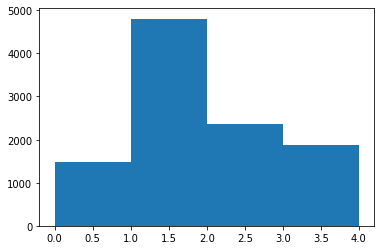

In [12]:
relevants_dist = [sum([doc['relevance'] for doc in p['documents']]) for p in training_json['rankingProblems']]
plt.hist(relevants_dist, bins=[0,1,2,3,4])
plt.show()

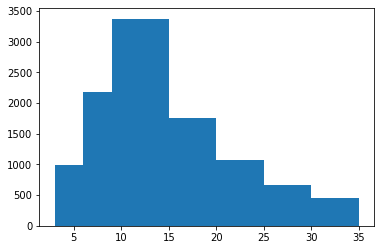

In [13]:
num_sents_dist = [len(p['documents']) for p in training_json['rankingProblems']]
plt.hist(num_sents_dist, bins=[3,6,9,15,20, 25, 30, 35])
plt.show()

In [84]:
def trim_documents(problem, max_sents=15):
    '''
    Take top 15 sentences, making sure that the relevant sentences are kept and then shuffle.
    '''
    sorted_by_rel = sorted(problem['documents'], key=lambda x: -x['relevance'])
    sorted_by_rel = sorted_by_rel[0:max_sents]
    np.random.shuffle(sorted_by_rel)
    problem['documents'] =  sorted_by_rel
    
    return problem

In [39]:
#Filter out cases with no attacks
training_json['rankingProblems'] = [trim_documents(problem) for problem in training_json['rankingProblems'] if sum([doc['relevance'] for doc in problem['documents']]) > 0] #put the relevnt documents on the beginning so when we cut they don't disappear
valid_json['rankingProblems']    = [trim_documents(problem) for problem in valid_json['rankingProblems']    if sum([doc['relevance'] for doc in problem['documents']]) > 0]
#Dont trim the test-set
testing_json['rankingProblems']  = [problem for problem in testing_json['rankingProblems']  if sum([doc['relevance'] for doc in problem['documents']]) > 0]

In [19]:
json.dump(training_json, open('/workspace/ceph_data/argument-undermining/data/vul_detection/training.json', 'w'))
json.dump(valid_json, open('/workspace/ceph_data/argument-undermining/data/vul_detection/valid.json', 'w'))
json.dump(testing_json, open('/workspace/ceph_data/argument-undermining/data/vul_detection/testing.json', 'w'))

In [20]:
print(len(training_json['rankingProblems']))
print(len(valid_json['rankingProblems']))
print(len(testing_json['rankingProblems']))

9908
2334
1244


In [101]:
testing_json = json.load(open('/workspace/ceph_data/argument-undermining/data/vul_detection/testing.json'))

In [110]:
s = {'rankingProblems':testing_json['rankingProblems'][0:2]}

In [111]:
json.dump(s, open('/workspace/ceph_data/argument-undermining/data/vul_detection/sample.json', 'w'))

#### Preparing jo data:

In [169]:
jo_df = pd.read_pickle('/workspace/ceph_data/argument-undermining/jo_data/vul_data.pickle')

In [170]:
jo_training_json = convert_jo_to_json (jo_df[jo_df.split=='train'])
jo_valid_json    = convert_jo_to_json(jo_df[jo_df.split=='val'])
jo_testing_json  = convert_jo_to_json(jo_df[jo_df.split=='test'])

In [171]:
print(len(jo_training_json['rankingProblems']))
print(len(jo_valid_json['rankingProblems']))
print(len(jo_testing_json['rankingProblems']))

25839
8763
8558


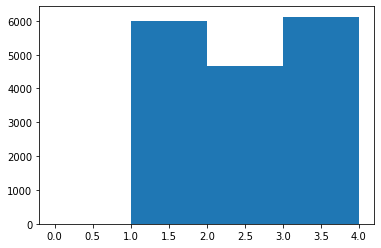

In [172]:
relevants_dist = [sum([doc['relevance'] for doc in p['documents']]) for p in jo_training_json['rankingProblems']]
plt.hist(relevants_dist, bins=[0,1,2,3,4])
plt.show()

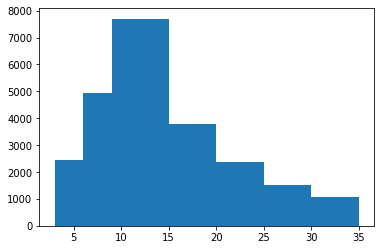

In [173]:
num_sents_dist = [len(p['documents']) for p in jo_training_json['rankingProblems']]
plt.hist(num_sents_dist, bins=[3,6,9,15,20, 25, 30, 35])
plt.show()

In [174]:
#Filter out cases with no attacks
#jo_training_json['rankingProblems'] = [trim_documents(problem, max_sents=30) for problem in jo_training_json['rankingProblems'] if sum([doc['relevance'] for doc in problem['documents']]) > 0] #put the relevnt documents on the beginning so when we cut they don't disappear
#jo_valid_json['rankingProblems']    = [trim_documents(problem, max_sents=30) for problem in jo_valid_json['rankingProblems']    if sum([doc['relevance'] for doc in problem['documents']]) > 0]
#don't trim the test-set
#jo_testing_json['rankingProblems']  = [problem for problem in jo_testing_json['rankingProblems']  if sum([doc['relevance'] for doc in problem['documents']]) > 0]

In [175]:
# num_sents_dist = [len(p['documents']) for p in jo_training_json['rankingProblems']]
# plt.hist(num_sents_dist, bins=[3,6,9,15,20, 25, 30, 35])
# plt.show()

In [176]:
json.dump(jo_training_json, open('/workspace/ceph_data/argument-undermining/data/vul_detection/jo_training.json', 'w'))
json.dump(jo_valid_json, open('/workspace/ceph_data/argument-undermining/data/vul_detection/jo_valid.json', 'w'))
json.dump(jo_testing_json, open('/workspace/ceph_data/argument-undermining/data/vul_detection/jo_testing.json', 'w'))

### Training Bert:

In [21]:
! python /workspace/computationally-undermining-arguments/thirdparty/ranking/tensorflow_ranking/extension/examples/tfrbert_convert_json_to_elwc.py \
    --vocab_file=/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2/vocab.txt \
    --sequence_length=128 \
    --input_file=/workspace/ceph_data/argument-undermining/data/vul_detection/training.json \
    --output_file=/workspace/ceph_data/argument-undermining/data/vul_detection/training.elwc.tfrecord \
    --do_lower_case 

2020-10-29 12:26:55.136957: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Utility to convert between JSON and ELWC for TFR-Bert

Model Parameters: 
Vocabulary filename: /workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2/vocab.txt
sequence_length: 128
do_lower_case: True


Input file:  /workspace/ceph_data/argument-undermining/data/vul_detection/training.json
Output file: /workspace/ceph_data/argument-undermining/data/vul_detection/training.elwc.tfrecord
Success.


In [22]:
! python /workspace/computationally-undermining-arguments/thirdparty/ranking/tensorflow_ranking/extension/examples/tfrbert_convert_json_to_elwc.py \
    --vocab_file=/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2//vocab.txt \
    --sequence_length=128 \
    --input_file=/workspace/ceph_data/argument-undermining/data/vul_detection/valid.json \
    --output_file=/workspace/ceph_data/argument-undermining/data/vul_detection/valid.elwc.tfrecord \
    --do_lower_case 

2020-10-29 12:29:03.432798: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Utility to convert between JSON and ELWC for TFR-Bert

Model Parameters: 
Vocabulary filename: /workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2//vocab.txt
sequence_length: 128
do_lower_case: True


Input file:  /workspace/ceph_data/argument-undermining/data/vul_detection/valid.json
Output file: /workspace/ceph_data/argument-undermining/data/vul_detection/valid.elwc.tfrecord
Success.


In [177]:
! python /workspace/computationally-undermining-arguments/thirdparty/ranking/tensorflow_ranking/extension/examples/tfrbert_convert_json_to_elwc.py \
    --vocab_file=/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2/vocab.txt \
    --sequence_length=128 \
    --input_file=/workspace/ceph_data/argument-undermining/data/vul_detection/jo_training.json \
    --output_file=/workspace/ceph_data/argument-undermining/data/vul_detection/jo_training.elwc.tfrecord \
    --do_lower_case 

2020-11-29 11:23:24.202122: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Utility to convert between JSON and ELWC for TFR-Bert

Model Parameters: 
Vocabulary filename: /workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2/vocab.txt
sequence_length: 128
do_lower_case: True


Input file:  /workspace/ceph_data/argument-undermining/data/vul_detection/jo_training.json
Output file: /workspace/ceph_data/argument-undermining/data/vul_detection/jo_training.elwc.tfrecord
Success.


In [178]:
! python /workspace/computationally-undermining-arguments/thirdparty/ranking/tensorflow_ranking/extension/examples/tfrbert_convert_json_to_elwc.py \
    --vocab_file=/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2//vocab.txt \
    --sequence_length=128 \
    --input_file=/workspace/ceph_data/argument-undermining/data/vul_detection/jo_valid.json \
    --output_file=/workspace/ceph_data/argument-undermining/data/vul_detection/jo_valid.elwc.tfrecord \
    --do_lower_case 

2020-11-29 11:30:40.689754: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Utility to convert between JSON and ELWC for TFR-Bert

Model Parameters: 
Vocabulary filename: /workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2//vocab.txt
sequence_length: 128
do_lower_case: True


Input file:  /workspace/ceph_data/argument-undermining/data/vul_detection/jo_valid.json
Output file: /workspace/ceph_data/argument-undermining/data/vul_detection/jo_valid.elwc.tfrecord
Success.


In [ ]:
#This is necessary for building the library
#bazel build -c opt bazel build -c opt tensorflow_ranking/extension/examples:tfrbert_example_py_binary

In [ ]:
#BERT_DIR="/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-2_H-128_A-2_TF2" #tiny-bert
BERT_DIR="/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2" #big-bert
DATA_DIR="/workspace/ceph_data/argument-undermining/data/vul_detection"
BAZIL_BIN="/workspace/computationally-undermining-arguments/thirdparty/ranking/bazel-bin/"

In [69]:
OUTPUT_DIR="/workspace/ceph_data/argument-undermining/models/vul_detection_listwise/"

! CUDA_VISIBLE_DEVICES=4 ${BAZIL_BIN}/tensorflow_ranking/extension/examples/tfrbert_example_py_binary \
   --train_input_pattern=${DATA_DIR}/training.elwc.tfrecord \
   --eval_input_pattern=${DATA_DIR}/valid.elwc.tfrecord \
   --bert_config_file=${BERT_DIR}/bert_config.json \
   --bert_init_ckpt=${BERT_DIR}/bert_model.ckpt \
   --bert_max_seq_length=128 \
   --model_dir="${OUTPUT_DIR}" \
   --loss=softmax_loss \
   --train_batch_size=1 \
   --convert_labels_to_binary \
   --eval_batch_size=1 \
   --listwise_inference True \
   --list_size=15 \
   --learning_rate=1e-6 \
   --num_train_steps=100000 \
   --num_eval_steps=200 \
   --checkpoint_secs=200 \
   --bert_num_warmup_steps 1000 \
   --num_checkpoints=5

/bin/sh: 1: /tensorflow_ranking/extension/examples/tfrbert_example_py_binary: not found


In [ ]:
OUTPUT_DIR="/workspace/ceph_data/argument-undermining/models/vul_detection_pointwise/"

CUDA_VISIBLE_DEVICES=1 ${BAZIL_BIN}/tensorflow_ranking/extension/examples/tfrbert_example_py_binary \
   --train_input_pattern=${DATA_DIR}/training.elwc.tfrecord \
   --eval_input_pattern=${DATA_DIR}/valid.elwc.tfrecord \
   --bert_config_file=${BERT_DIR}/bert_config.json \
   --bert_init_ckpt=${BERT_DIR}/bert_model.ckpt \
   --bert_max_seq_length=128 \
   --model_dir="${OUTPUT_DIR}" \
   --loss=sigmoid_cross_entropy_loss \
   --listwise_inference=True\
   --train_batch_size=1 \
   --convert_labels_to_binary=True \
   --eval_batch_size=1 \
   --list_size=15 \
   --learning_rate=1e-6 \
   --num_train_steps=100000 \
   --num_eval_steps=200 \
   --checkpoint_secs=200 \
   --bert_num_warmup_steps 1000 \
   --num_checkpoints=5

In [ ]:
OUTPUT_DIR="/workspace/ceph_data/argument-undermining/models/vul_detection_pairwise/"

CUDA_VISIBLE_DEVICES=2 ${BAZIL_BIN}/tensorflow_ranking/extension/examples/tfrbert_example_py_binary \
   --train_input_pattern=${DATA_DIR}/training.elwc.tfrecord \
   --eval_input_pattern=${DATA_DIR}/valid.elwc.tfrecord \
   --bert_config_file=${BERT_DIR}/bert_config.json \
   --bert_init_ckpt=${BERT_DIR}/bert_model.ckpt \
   --bert_max_seq_length=128 \
   --model_dir="${OUTPUT_DIR}" \
   --loss=pairwise_logistic_loss \
   --listwise_inference=True\
   --train_batch_size=1 \
   --convert_labels_to_binary=True \
   --eval_batch_size=1 \
   --list_size=15 \
   --learning_rate=1e-6 \
   --num_train_steps=100000 \
   --num_eval_steps=200 \
   --checkpoint_secs=200 \
   --bert_num_warmup_steps 1000 \
   --num_checkpoints=5

#### For Jo training:

In [ ]:
BERT_DIR="/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2" #big-bert
DATA_DIR="/workspace/ceph_data/argument-undermining/data/vul_detection"
BAZIL_BIN="/workspace/computationally-undermining-arguments/thirdparty/ranking/bazel-bin/"

OUTPUT_DIR="/workspace/ceph_data/argument-undermining/models/jo_vul_detection_pairwise/"

CUDA_VISIBLE_DEVICES=3 ${BAZIL_BIN}/tensorflow_ranking/extension/examples/tfrbert_example_py_binary \
   --train_input_pattern=${DATA_DIR}/jo_training.elwc.tfrecord \
   --eval_input_pattern=${DATA_DIR}/jo_valid.elwc.tfrecord \
   --bert_config_file=${BERT_DIR}/bert_config.json \
   --bert_init_ckpt=${BERT_DIR}/bert_model.ckpt \
   --bert_max_seq_length=128 \
   --model_dir="${OUTPUT_DIR}" \
   --loss=pairwise_logistic_loss \
   --listwise_inference=True\
   --train_batch_size=1 \
   --convert_labels_to_binary=True \
   --eval_batch_size=1 \
   --list_size=15 \
   --learning_rate=1e-5 \
   --num_train_steps=100000 \
   --num_eval_steps=200 \
   --checkpoint_secs=200 \
   --bert_num_warmup_steps 1000 \
   --num_checkpoints=5

### Testing models:

Setting up the prediction server:

In [ ]:
 #!/bin/bash
export MODEL_DIR=/workspace/ceph_data/argument-undermining/models/vul_detection_listwise/export/best_model_by_loss/
CUDA_VISIBLE_DEVICES=2 tensorflow_model_server \
  --port=8503 \
  --rest_api_port=8501 \
  --model_name=tfrbert \
  --model_base_path="${MODEL_DIR}"

export MODEL_DIR=/workspace/ceph_data/argument-undermining/models/vul_detection_pointwise/export/best_model_by_loss/
CUDA_VISIBLE_DEVICES=2 tensorflow_model_server \
  --port=8503 \
  --rest_api_port=8501 \
  --model_name=tfrbert \
  --model_base_path="${MODEL_DIR}"

export MODEL_DIR=/workspace/ceph_data/argument-undermining/models/vul_detection_pairwise/export/best_model_by_loss/
CUDA_VISIBLE_DEVICES=0 tensorflow_model_server \
  --port=8503 \
  --rest_api_port=8501 \
  --model_name=tfrbert \
  --model_base_path="${MODEL_DIR}"

In [ ]:
#!/bin/bash
BERT_DIR="/workspace/ceph_data/argument-undermining/models/thirdparty/uncased_L-12_H-768_A-12_TF2"
DATA_DIR="/workspace/ceph_data/argument-undermining/data/vul_detection"

python tensorflow_ranking/extension/examples/tfrbert_client_predict_from_json.py \
    --vocab_file=${BERT_DIR}/vocab.txt \
    --sequence_length=128 \
    --input_file=${DATA_DIR}/testing.json \
    --output_file=${DATA_DIR}/pred-test-best-loss.json \
    --do_lower_case

In [204]:
gt_data = json.load(open('/workspace/ceph_data/argument-undermining/data/vul_detection/jo_testing.json'))
preds_listwise = json.load(open('/workspace/ceph_data/argument-undermining/data/vul_detection/listwise-pred-jo-test-tmp.json'))
preds_pointwise= json.load(open('/workspace/ceph_data/argument-undermining/data/vul_detection/pointwise-pred-jo-test.json'))
preds_pairwise = json.load(open('/workspace/ceph_data/argument-undermining/data/vul_detection/pairwise-pred-jo-test.json'))

In [251]:
def prec_at(ranking_problems, baseline=None, k=1):
    correct_cases = 0
    total_num_cases = 0
    for problem in ranking_problems:
#         if sum([x['relevance'] for x in problem['documents']]) == 0: #no relevance
#             print('no relevance')
#             continue
        
        if baseline != None:
            if baseline == 'sen_length':
                selected_premises = sorted(problem['documents'], key=lambda x: -len(nltk.word_tokenize(x['docText'])))[0:k]
            else:
                selected_premises = np.random.choice(problem['documents'], k)
        else:
            selected_premises = sorted(problem['documents'], key=lambda x: -x['score'])[0:k]

        if 1 in [x['relevance'] for x in selected_premises]:
            correct_cases+=1
        
        total_num_cases+=1
        
    return round(correct_cases/total_num_cases, 3)

def compute_ndcg(ranking_problems, baseline=None, k=1):
    ndcgs = []
    
    if baseline != None:
        if baseline == 'sen_length':
            pred_relevance = [[len(nltk.word_tokenize(doc['docText'])) for doc in p['documents']] for p in ranking_problems]
        else:
            pred_relevance = [[np.random.uniform(0,1) for doc in p['documents']] for p in ranking_problems]
    else:
        pred_relevance = [[doc['score'] for doc in p['documents']] for p in ranking_problems]
        
    true_relevance = [[doc['relevance'] for doc in p['documents']] for p in ranking_problems]

    for x, y in zip(true_relevance, pred_relevance):
        if len(x) == 1:
            #print('...')
            continue
        ndcgs.append(ndcg_score([x], [y], k=k))

    return round(np.mean(ndcgs), 2)

def perform_significance_tests(app1_preds, app2_preds):
    all_data = np.array(list(zip(app1_preds, app2_preds)))
    chunks = np.array_split(all_data, 10)
    
    app1_chunks_scores = []
    app2_chunks_scores = []
    for chunk in chunks:
        app1_chunk, app2_chunk = list(zip(*chunk))
        app1_chunks_scores.append((prec_at(app1_chunk, k=1),  prec_at(app1_chunk, k=3)))
        app2_chunks_scores.append((prec_at(app2_chunk, k=1),  prec_at(app2_chunk, k=3)))
        

    sig_report = {}
    for idx, measure in enumerate(['P@1', 'Acc@3']):
        s1 = [round(s[idx], 3) for s in app1_chunks_scores]
        s2 = [round(s[idx], 3) for s in app2_chunks_scores]

        sig_report[measure] = {'@5%':evaluation.check_sig(s2, s1, alpha=0.05), 
                               '%10': evaluation.check_sig(s2, s1, alpha=0.1)
        }
        
    return sig_report

In [243]:
#Load jo preds and convert them to the same structure of ours..
jo_preds_df = pd.read_csv('../logs/attack-20201214_083700-Mbert-NMdomain-FT-DMdomain40-DAFalse-FD0-WCTrue-insts-test.csv')
jo_preds_df['sentence'] = jo_preds_df.apply(lambda row: {'sen_id': row['sentence_no'], 'relevance' : row['y_true'], 'score': row['y_pred']}, axis=1)
jo_preds_df = jo_preds_df.groupby('post_id').agg({'sentence': lambda x: list(x)}).reset_index()

jo_preds = {'rankingProblemsOutput': []}
for idx, post in jo_preds_df.iterrows():
    jo_preds['rankingProblemsOutput'].append({'queryText': '', 'documents': post['sentence']})

In [236]:
listwise_model_scores  = [ prec_at(preds_listwise['rankingProblemsOutput'], k=1),  prec_at(preds_listwise['rankingProblemsOutput'], k=3)]
pointwise_model_scores = [ prec_at(preds_pointwise['rankingProblemsOutput'], k=1),  prec_at(preds_pointwise['rankingProblemsOutput'], k=3)]
pairwise_model_scores = [ prec_at(preds_pairwise['rankingProblemsOutput'], k=1),  prec_at(preds_pairwise['rankingProblemsOutput'], k=3)]
jo_scores = [ prec_at(jo_preds['rankingProblemsOutput'], k=1),  prec_at(jo_preds['rankingProblemsOutput'], k=3)]
#baseline_scores_sen_length = [ prec_at(gt_data['rankingProblems'], baseline='sen_length', k=1),  prec_at(gt_data['rankingProblems'], baseline='sen_length', k=3)]
#baseline_scores_random = [ prec_at(gt_data['rankingProblems'], baseline='random', k=1),  prec_at(gt_data['rankingProblems'], baseline='random', k=3)]

In [238]:
print(tabulate([
    ['Sentence Length'] + baseline_scores_sen_length,
    ['Random'] + baseline_scores_random,
    ['Jo et al.']+ jo_scores,
    ['LTR-bert (point-wise)'] + pointwise_model_scores,
    ['LTR-bert (pair-wise)'] + pairwise_model_scores,
    ['LTR-bert (list-wise)'] + listwise_model_scores,
], headers=['#', 'P@1', 'A@3']))

#                        P@1    A@3
---------------------  -----  -----
Sentence Length        0.425  0.738
Random                 0.35   0.617
Jo et al.              0.487  0.777
LTR-bert (point-wise)  0.505  0.787
LTR-bert (pair-wise)   0.498  0.78
LTR-bert (list-wise)   0.506  0.786


In [255]:
perform_significance_tests(jo_preds['rankingProblemsOutput'], preds_listwise['rankingProblemsOutput'])

{'P@1': {'@5%': True, '%10': True}, 'Acc@3': {'@5%': True, '%10': True}}

In [256]:
perform_significance_tests(jo_preds['rankingProblemsOutput'], preds_pointwise['rankingProblemsOutput'])

{'P@1': {'@5%': True, '%10': True}, 'Acc@3': {'@5%': True, '%10': True}}

In [257]:
perform_significance_tests(jo_preds['rankingProblemsOutput'], preds_pairwise['rankingProblemsOutput'])

{'P@1': {'@5%': True, '%10': True}, 'Acc@3': {'@5%': False, '%10': False}}